# Racial disparities in Boston FIO data
 
Boston Mayor Marty Walsh [declared racism a public health crisis in June 2020](https://www.npr.org/sections/live-updates-protests-for-racial-justice/2020/06/12/876327158/boston-mayor-declares-racism-a-public-health-crisis), committing to reallocating $3 million from the city's police department to public health accounts. Racism and discrimination in Boston is nothing new. 

Black people were more likely to be stopped by the Boston Police officers, [according to data](https://www.wgbh.org/news/local-news/2020/06/12/black-people-made-up-70-percent-of-boston-police-stops-department-data-show) collected by the Field Interrogation and Observation (FIO) program. The FIO records include interactions between the BPD and indivisuals from 2011 to 2019. Through analyzing the records, we can get a sense of whether racial bias exists in stop decisions.

Data sources:
- [BPD FIO data](https://data.boston.gov/dataset/boston-police-department-fio) (2011 - 2019, I'm using data between 2015 and 2019)

Check it out here to see how I cleaned the dataset: https://github.com/sabrinamochi/bpd_fio_data_analysis/blob/master/data-cleaning-in-general.ipynb

Not only people stopped by the police were recorded, people "observed" by the police officers were also documented in the dataset...

Questions I want to answer:
- Are there any biases in stop decisions? If yes, why(contact reasons)?
- Biases in post-stop decisions: which stopped people were frisked?
- Any significant changes after the legalization of recreational marijuana?
- Do field contacts involved with certain officers lead to higher possibility of getting frisked/searched?
- Different patterns in different neighborhoods? stop-and-frisk hotspots?

In [1]:
# import packages
import pandas as pd
import re
import datetime
import missingno as msno
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

In [2]:
plc = pd.read_csv("cleaned_fc_data_2015_2019.csv")
indvsl = pd.read_csv("cleaned_fc_name_data_2015_2019.csv")

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


* The BPD has been releasing FIO reports since 2010, containing interaction details between the BPD officers and indivisuals. The BPD FIOs depart from other states' frisk-and-stops practices in including a broader spectrum of police practices -- non-contact observations, direct encounters and investigative stops. Therefore, the datasets include direct encounters, investigative stops and non-contact observations. In this analysis, I focus only on people who were stopped by the police.
* I did not focus on Hispanic people in my analysis because after 2015, the race categories in new FIO report system only include white, black, asian, native american / alaskan native, native hawaiian / other pacific islander, unknown and others. 

In [3]:
# plc_noOb = plc[plc.circumstance != 'observed']
plc_stopped = plc[plc.circumstance == 'stopped']

### Stops and frisks by year
Between 2015 and 2019, BPD made 25,441 investigative stops. The yearly number of people being stopped and frisked have declined since 2017.

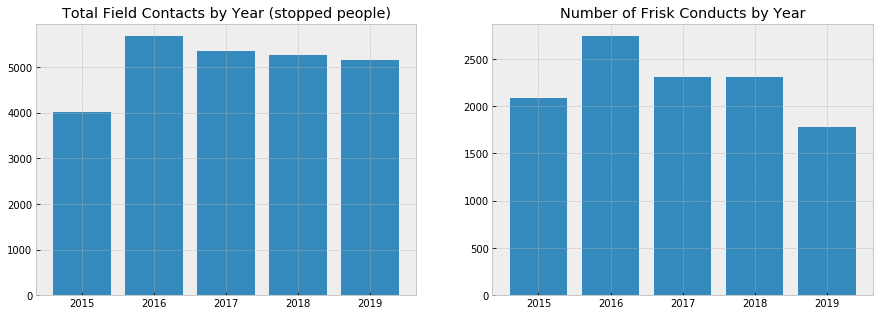

In [4]:
frisked_involved = plc_stopped[plc_stopped.person_involved_in_frisked_or_searched == "y"].reset_index(drop=True)
yearly_fc = plc_stopped.groupby(["year"]).count()[["contact_date"]]
yearly_frisked = frisked_involved.groupby(["year"]).count()[["contact_date"]]
year_list=[2015, 2016, 2017, 2018, 2019]
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(15, 5))
ax1.bar(year_list, yearly_fc["contact_date"])
ax2.bar(year_list, yearly_frisked["contact_date"])
ax1.set_title('Total Field Contacts by Year (stopped people)')
ax2.set_title('Number of Frisk Conducts by Year')
plt.xticks([2015, 2016, 2017, 2018, 2019])
plt.show()

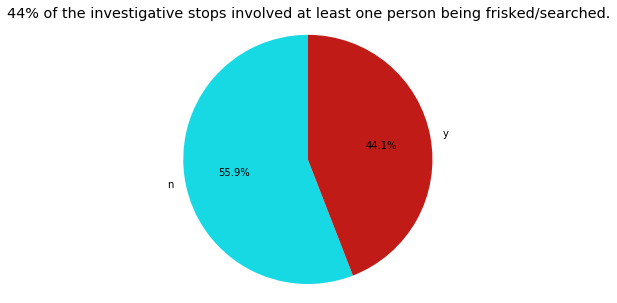

In [5]:
frisked_percent = plc_stopped.person_involved_in_frisked_or_searched.value_counts(normalize=True, dropna=False).to_frame().reset_index().rename(columns={"index": "type"})
fig, ax = plt.subplots(figsize=(5,5))
ax.pie(frisked_percent["person_involved_in_frisked_or_searched"], labels=frisked_percent["type"], autopct='%1.1f%%',
        startangle=90, colors=["#17D9E3", "#C11B17"])
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("44% of the investigative stops involved at least one person being frisked/searched.")
plt.show()

### Who were stopped?
From 2015 to 2019, people stopped by the police were mostly young, male(89%) and Black(69%). 

In [6]:
df_num = indvsl.select_dtypes(include=['float64', 'int64'])
df_num[['age']].describe()

,age
count,68762.000000
mean,28.650039
std,10.303265
min,1.000000
25%,21.000000
50%,26.000000
75%,33.000000
max,93.000000


In [7]:
indvsl.sex.value_counts(dropna=False, normalize=True)

male                          0.888905
female                        0.104668
NaN                           0.005065
unknown                       0.000653
transgender male to female    0.000539
transgender female to male    0.000170
Name: sex, dtype: float64

In [8]:
indvsl.race.value_counts(dropna=False, normalize=True)

black                                       0.687599
white                                       0.244821
unknown                                     0.053916
asian                                       0.006427
NaN                                         0.005690
native american / alaskan native            0.000610
native hawaiian / other pacific islander    0.000553
other                                       0.000383
Name: race, dtype: float64

### Who were involved in a frisk conduct?

From 2015 to 2019, people who were stopped and involved in a frisk conduct (including vehicle search) by the police were mostly young, male and Black as well. 

In [9]:
indvsl_inv_f = indvsl[indvsl.person_involved_in_frisked_or_searched == "y"]
df_num = indvsl_inv_f.select_dtypes(include=['float64', 'int64'])
df_num[['age']].describe()

,age
count,22358.000000
mean,27.881921
std,10.161267
min,1.000000
25%,21.000000
50%,25.000000
75%,32.000000
max,92.000000


In [10]:
indvsl_inv_f.sex.value_counts(dropna=False, normalize=True)

male                          0.902191
female                        0.095355
NaN                           0.001578
unknown                       0.000351
transgender male to female    0.000351
transgender female to male    0.000175
Name: sex, dtype: float64

In [11]:
indvsl_inv_f.race.value_counts(dropna=False, normalize=True)

black                                       0.699167
white                                       0.231113
unknown                                     0.060079
asian                                       0.006529
NaN                                         0.001578
native hawaiian / other pacific islander    0.000876
native american / alaskan native            0.000657
Name: race, dtype: float64

*Specific indivisuals getting frisked more by the police. are they gang members?

According to the U.S. Census Bureau, in 2019, Boston had 692,600 residents that were 48.1 percent male and 25.3 percent Black. This phenomenon lead to controversies over the FIO practices. 

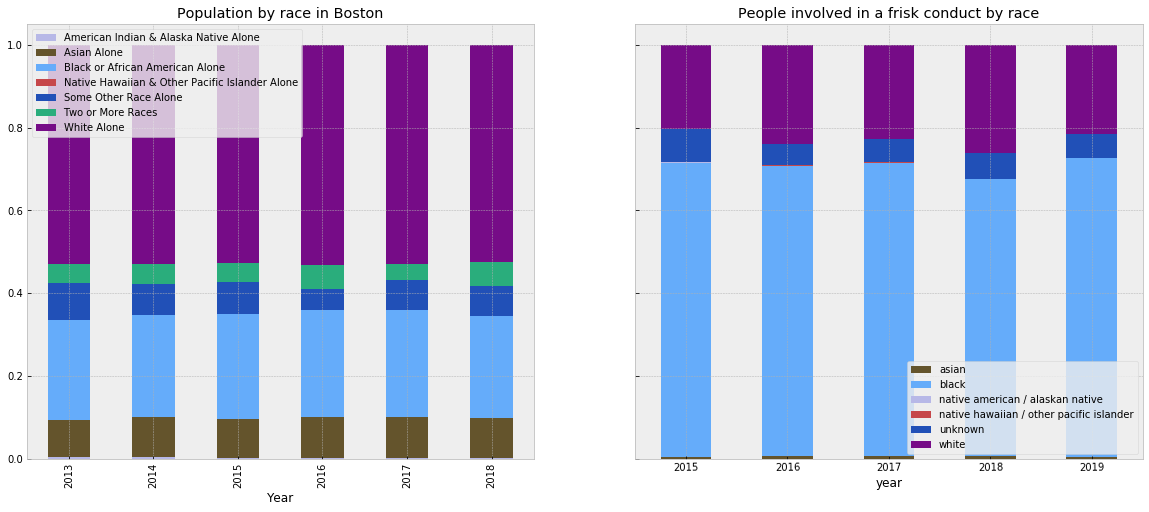

In [12]:
# census data: https://datausa.io/profile/geo/boston-ma/#demographics 
census = pd.read_csv("data/race_and_eth_boston.csv")
census = census[["Race", "Year", "share"]].reset_index(drop=True)
census = census.groupby(["Race", "Year"], as_index=False).sum()
pivot_census = census.pivot_table(index='Year', columns='Race', values='share')

grouped_year_race = indvsl_inv_f.groupby(["year", "race"]).agg({"contact_date": "count"})
grouped_year_race_pcts = grouped_year_race.groupby(level=0).apply(lambda x:
                                               100 * x / float(x.sum()))
grouped_year_race_pcts = grouped_year_race_pcts.rename(columns={"contact_date": "percentage"})
# use unstack()
unstacked = grouped_year_race_pcts['percentage'].unstack(level=0)
unstacked = unstacked.div(unstacked.sum())

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
pal1 = ["#b7b8e7", "#64542c", "#65acfa", "#c6474a", "#2150b7", "#2aad7c", "#760c87"]
pal2 = ["#64542c", "#65acfa", "#b7b8e7","#c6474a", "#2150b7", "#760c87"]

pivot_census.plot.bar(ax=ax1, stacked=True, figsize=(20,8), color=pal1)
ax1.set_title("Population by race in Boston")
ax1.legend(loc='upper left')

unstacked.T.plot(ax=ax2, kind='bar', stacked=True, rot=1, figsize=(20, 8), color=pal2,
               title="% of stops by race")
ax2.set_title("People involved in a frisk conduct by race")
ax2.legend(loc='lower right')


In investigative stops with no black people involved, 38% of them included a frisk/search conduct. For investigative stops with at least one black person involved, 47% of them included a frisk/search conduct.

In [13]:
b_indvsl_involved = indvsl.groupby("fc_num").apply(
    lambda x: "y"
    if (x.race == "black").any()
    else "n"
    )
plc_stopped["black_people_involved"] = plc_stopped[
    "fc_num"
].apply(lambda x: b_indvsl_involved[x])
frisked_val = plc_stopped[plc_stopped["person_involved_in_frisked_or_searched"].notna()]
pd.crosstab(frisked_val.person_involved_in_frisked_or_searched, frisked_val.black_people_involved).apply(lambda r: r/r.sum(), axis=0)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


black_people_involved,n,y
person_involved_in_frisked_or_searched,,
n,0.616432,0.532526
y,0.383568,0.467474


So... does this testify racial disparities in policing? Many factors can influence a police officer's decision to frisk or search the person. The police officer may often take racial distribution in crime history into consideration. For example, let's look at the drug arrest rates across different racial groups. 

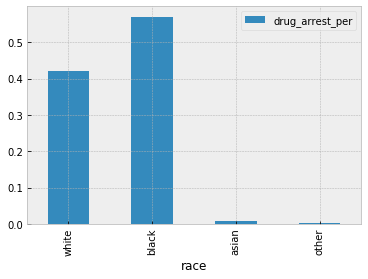

In [14]:
# data from: https://www.cityofboston.gov/Images_Documents/2008Crime%20Summary_tcm3-8952.pdf
year = [2008, 2008, 2008, 2008]
race = ["white", "black", "asian", "other"]
drug_arrest_per = [0.4205, 0.5707, 0.00717, 0.00162]
drugArrest2008 = pd.DataFrame({"year": year, "race": race, "drug_arrest_per": drug_arrest_per})
drugArrest2008.plot(kind="bar", x="race", y="drug_arrest_per")

While white people make up 42% of the total drug arrests, Black people make up 57% of them. Racial distribution in crime history like this could possibly affect the police officer's judgement when it comes to conducting a frisk/search practice.  

## 20% of police officers contributed to 80% of frisks.

In [73]:
totalNum_officer = len(plc_stopped.contact_officer.unique())
print("total number of police officers: " + str(totalNum_officer))

total number of police officers: 1474


In [74]:
stop_conduct_by_officers = plc_stopped.contact_officer.value_counts().reset_index().rename(columns={"index": "officer", "contact_officer":"stop_conduct_counts"})
frisk_conduct_by_officers = frisked_involved.contact_officer.value_counts().reset_index().rename(columns={"index": "officer", "contact_officer":"frisk_conduct_counts"})

In [82]:
numOfOfficer = 300
perOfOfficer = round(numOfOfficer/totalNum_officer, 3)
perOfOffMakeStop = round(stop_conduct_by_officers[:numOfOfficer]["stop_conduct_counts"].sum()/plc_stopped.shape[0], 3)
print(str("{0:.0%}".format(perOfOfficer))+" of police officers contributed to " + str("{0:.0%}".format(perOfOffMakeStop)) + " of investigative stops.")

20% of police officers conduct 79% of investigative stops.


In [89]:
numOfOfficer = 300
perOfOfficer = round(numOfOfficer/totalNum_officer, 3)
perOfOffMakeFrisk = round(frisk_conduct_by_officers[:numOfOfficer]["frisk_conduct_counts"].sum()/frisked_involved.shape[0], 3)
print(str("{0:.0%}".format(perOfOfficer))+" of police officers contributed to " + str("{0:.0%}".format(perOfOffMakeFrisk)) + " of frisks.")


20% of police officers contributed to 80% of frisks.


In [101]:
topStopOff = stop_conduct_by_officers[:100]["officer"].tolist()
topFriskOff = frisk_conduct_by_officers[:100]["officer"].tolist()
topStopFriskOff = []
for n in topStopOff:
    if n in topFriskOff:
        topStopFriskOff.append(n)

print(str(len(l)) + " of the top 100 stoppers are also the top 100 friskers. who did they stop and frisk?")

78 of the top 100 stoppers are also the top 100 friskers. who did they stop and frisk?


In [174]:
topStopFriskDf = frisked_involved[frisked_involved.contact_officer.isin(topStopFriskOff)].reset_index(drop=True)
topStopFriskDf["black_people_involved"].value_counts(normalize=True)

y    0.797297
n    0.202703
Name: black_people_involved, dtype: float64

#### !!!Data Constraints!!!

"While these two tables align on the field contact number (fc_num) column, it is not methodologically correct to join the two datasets for the purpose of generating aggregate statistics on columns from the FieldContact table. Doing so would lead to incorrect estimates stemming from contacts with multiple individuals. As noted in the Data Key (New RMS) file, several of the columns in the FieldContact table apply to the contact as a whole, but may not necessarily apply to each individual involved in the contact." These include:

- frisked
- searchperson
- summonsissued
- circumstances
- basis
- contact_reason
